# Nuestro primer modelo

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/03_modelo_lineal.ipynb)


Vamos a empezar con un primer modelo sencillo. Va a ser un modelo lineal y no va a funcionar demasiado bien, pero nos va a servir para incorporar los conceptos importantes de a poco. 

Pero primero, vamos a repetir la pipeline que creamos en la sección anterior. Nuestro objetivo con este dataset es crear un clasificador que distinga perros y gatos

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

# cargamos el dataset
(train_data, validation_data), info = tfds.load('cats_vs_dogs', split=["train[:75%]", "train[75%:]"], with_info=True)


# definimos las transformaciones que vamos a aplicar a las imagenes

def select_data(example):
    """ Return an (image, label) tuple """
    return example["image"], example["label"]

def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label
              

def resize(image, label):
    """ Resize the image"""
    image = tf.image.resize(image, [32, 32], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

def flatten(image, label):
    """ Flatten the image to a single column vector"""
    image = tf.reshape(image, shape=[-1, 1])
    return image, label

def pipeline(dataset):
    dataset = dataset.map(select_data)
    dataset = dataset.map(normalize)
    dataset = dataset.map(resize)
    dataset = dataset.map(flatten)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# le aplicamos la misma pipeline a nuestro dataset de entrenamiento y de validación

train_data = pipeline(train_data)
validation_data = pipeline(validation_data)

2023-11-18 12:18:33.972061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 12:18:34.887509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 12:18:34.890438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tfds.__version__

'4.9.2'

Habíamos dicho que los aspectos más importantes del aprendizaje automático eran:

1. Tener un modelo que determina un resultado a partir de datos y "parámetros" internos.
2. Que el resultado del modelo pueda ser evaluado (automáticamente) a través de alguna métrica de rendimiento.
3. Que exista un mecanismo automático para mejorar el rendimiento a través de la modificación de los parámetros internos.

Vayamos en orden empezando por 1)

## Clasificador lineal: de imágenes a etiquetas

En nuestro dataset de entrenamiento tenemos $N = 17446$ imágenes. Cada imagen tiene $32 \times 32$ pixels, representado por tres colores RGB (tres canales por imagen). Podemos representar cada imagen como $D = 32 \times 32 \times 3 = 3072$ valores. Finalmente, sabemos que hay un total de $K = 2$ clases: gato y perro.

Podemos intentar una función lineal $f$ que mapee las imágenes a las etiquetas de la siguiente forma:

$$f(x_i, W, b) = W x_i + b = \sum_{k=1}^D w_k x_i^k + b $$

Donde estamos asumiendo que $x_i$ es un vector de una columna con dimension [$D \times 1$] (o sea, aplastamos la imagen en una lista de $32 \times 32 \times 3 = 3072$ números). $W$ es una matriz de dimensión [$1 \times D$] (queremos un número por cada peso), esta matriz contiene la mayoría de los pesos (o parámetros) de nuestro modelo. Finalmente, $b$ es un vector de bias (sesgo) de dimensión [$1$]. El vector de bias nos permite trasladar el resultado en una dirección a otra sin modificar los pesos $W$.



Después de aplicar el producto de la matriz por el vector $x_i$, le sumamos el vector bias $b$. El resultado es simplemente un número, podemos asociar cada uno de esos valores a un "score" (puntaje) para que la etiqueta correcta sea gato o perro. Si el score es alto, es más probable que la imagen muestre un perro, mientras que si es bajo, probablemente sea un gato.

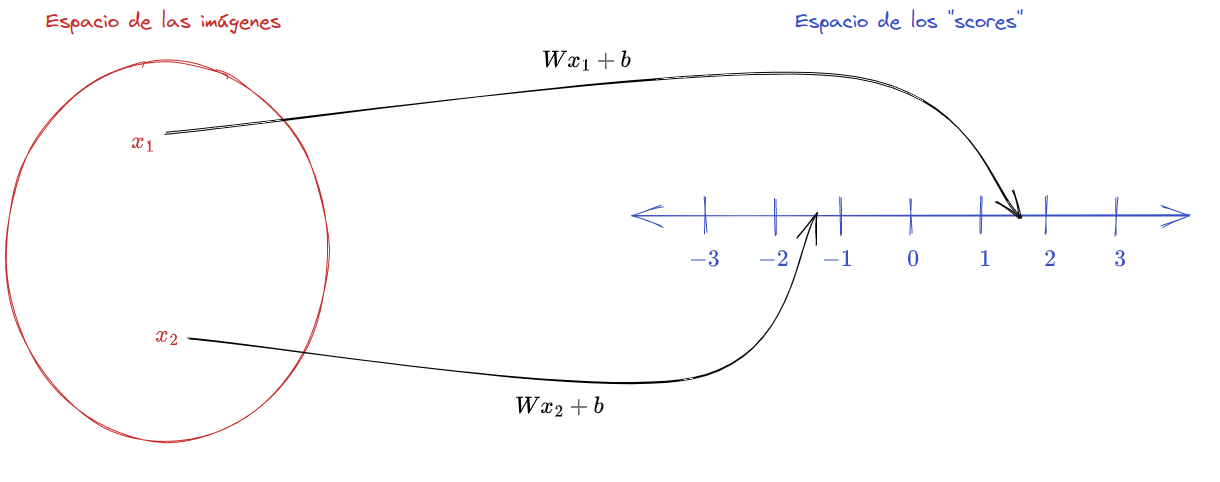

<!-- ![Un simple modelo lineal que mapea las imágenes a un puntaje](images/modelo_lineal.png) -->



Por supuesto, esta no la única forma de resolver este problema. Estamos planteando el modelo más simple posible. Probablemente no funcione demasiado bien porque las transformaciones lineales, que en esencia es lo que está haciendo la función $f$, son un poco limitadas. No son capaces de "deformar" suficientemente el espacio de entrada para llevarlo a un espacio de resultados que separe las clases lo suficiente. Esta es una limitación matemática de este tipo de operaciones. 

En el transcurso del curso vamos a ver soluciones y mejoras a este tipo de modelos, por ahora esto nos sirve porque ilustra de forma sencilla los pasos a seguir.

## Evaluando el modelo: función de perdida

Es el turno ahora de encarar el punto 2 de nuestro tres aspectos fundamentales: evaluar las predicciones del modelo de forma automática. Para ello se suele buscar lo que se denomina función de pérdida: una función que dado los datos y las predicciones, nos diga que tan bien se comparta el modelo. Por convección se suele evaluar la pérdida, es decir, cuanto mayor es el valor numérico de la función de pérdida, peor es el modelo.

El problema por ahora es que el modelo nos devuelve un score, pero los datos verdaderos (las etiquetas) son simplemente ceros y unos. Necesitamos alguna forma de **comparar** las predicciones con las etiquetas para poder decir si el modelo funciona o no. 

### Función sigmoide

Lo que podemos hacer es restringir los scores a valores entre 0 y 1. Para ello resulta muy útil la función sigmoide:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

que justamente tiende asintóticamente a cero si el valor es mucho menor a 0, mientras que tiende asintóticamente a 1 si es mucho mayor a cero.

Podemos graficar rápidamente la función:

In [4]:
import seaborn as sns
sns.set_theme()

Text(0.5, 0, 'z')

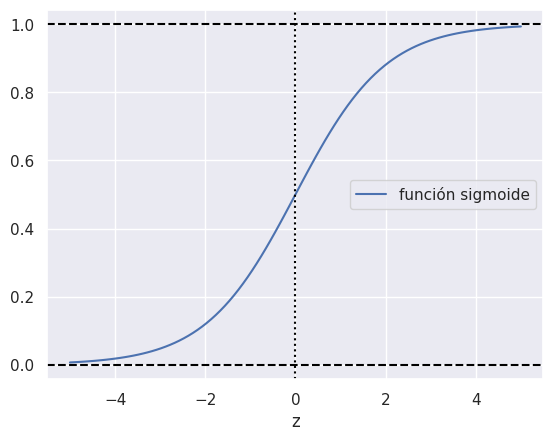

In [5]:
def sigmoid(z):
    return 1 / (1 + tf.math.exp(-z))

z = tf.linspace(-5, 5, 100)

ax = sns.lineplot(x=z, y=sigmoid(z), label="función sigmoide")

ax.axhline(1, linestyle="--", color="black")
ax.axhline(0, linestyle="--", color="black")
ax.axvline(0, linestyle=":", color="black")
ax.set_xlabel('z')


### Función de pérdida: Binary cross entropy

Ahora que nuestro scores están restringidos, parece más factible hacer la comparación, pero ¿de qué forma exactamente?. En el caso de clasificaciones binarias (donde solo hay dos clases posibles) se suele utilizar una fórmula conocida como binary cross entropy, según la cual se penalizan los resultados incorrectos. Veamos.

Tenemos dos casos posibles: 

1. La etiqueta es uno.

En este caso queremos penalizar las predicciones que se acerquen al cero, así que parece razonable considerar como pérdida menos el logaritmo natural de la predicción, ya que el logaritmo de un número que tiende a cero, tiende a $-\inf$. Además, el logaritmo de 1 es igual a cero, con lo cual la función de pérdida se anula cuando la etiqueta y las predicciones coinciden

$$ L_{y_\text{true} == 1} = -\log(y_\text{pred}) $$

Text(0.5, 0, '$y_{pred}$')

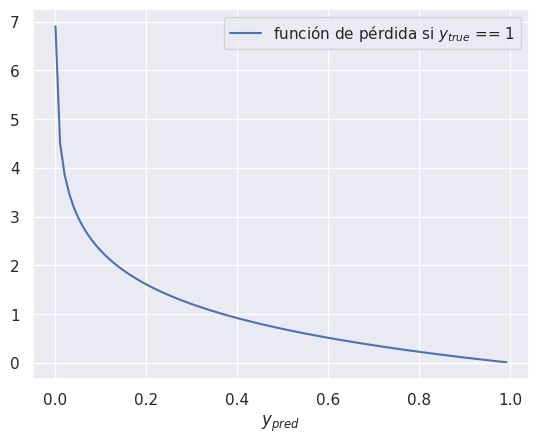

In [6]:
y_pred = tf.range(0.001, 1, 0.01)

ax = sns.lineplot(x=y_pred, y=-tf.math.log(y_pred), label="función de pérdida si $y_{true}$ == 1")
ax.set_xlabel('$y_{pred}$')


2. La etiqueta es cero.

Podemos hacer algo parecido usando esta vez el logaritmo de ($1 - {y_{pred}}$)

$$ L_{y_\text{true} == 0} = -\log(1 - y_\text{pred}) $$

En este caso, la función de pérdida explota si la predicción es 1 y es cero si la predicción es cero. 

Text(0.5, 0, '$y_{pred}$')

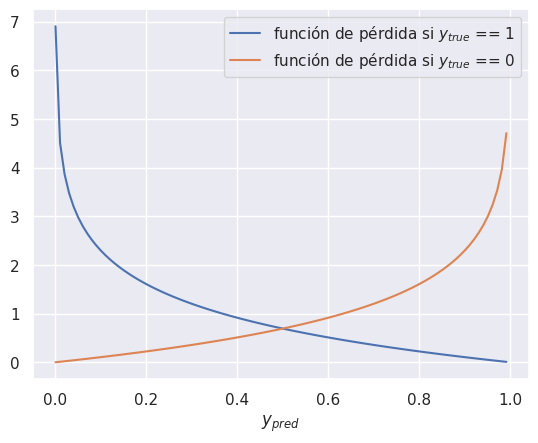

In [7]:
ax = sns.lineplot(x=y_pred, y=-tf.math.log(y_pred), label="función de pérdida si $y_{true}$ == 1")
ax = sns.lineplot(x=y_pred, y=-tf.math.log(1 - y_pred), label="función de pérdida si $y_{true}$ == 0")
ax.set_xlabel('$y_{pred}$')


Por conveniencia, podemos juntar ambas ramas en una sola expresión y obtener la versión canónica de binary cross entropy:

$$ L^i = - \left[ y_\text{true}^i \log{y_\text{pred}^i} + (1 - y_\text{true}^i) \log{(1 - y_\text{pred}^i)} \right] $$

donde $i$ refiere aquí a cada imagen o ejemplo. Noten que sólo una rama contribuye al resultado, dependiendo de si $y_\text{true}$ es cero o uno.


Para evaluar el desempeño del modelo poder ahora tomar el promedio sobre todas las imagenes:

$$ L = \frac{1}{N} \sum_{i}^{N} L^{i} = \frac{1}{N} \sum_{i}^{N} - \left[ y_\text{true}^i \log{y_\text{pred}^i} + (1 - y_\text{true}^i) \log{(1 - y_\text{pred}^i)} \right] $$

Si bien esta función de pérdida no parece muy complicada de implementar, existen algunas sutilizas. Principalmente, la forma más ingenua de escribirla no tiene en cuenta la estabilidad numérica y puede resultar en casos de valores de score extremos en los que la función sigmoide devuelva ceros o unos, haciendo estallar el logaritmo. Afortunadamente, existe en TensorFlow la función `tf.nn.sigmoid_cross_entropy_with_logits` una implementación numéricamente estable de la cross entropy. 

Tengan en cuenta que `tf.nn.sigmoid_cross_entropy_with_logits` aplica primero la función sigmoide a las predicciones, con lo cual lo que espera como entrada son las etiquetas y el score. 

Una implementación del cálculo completo podría ser algo parecida a esto:

In [8]:
# define and initialize model parameters
W = tf.random.normal(shape=[1, 3072])
b = tf.zeros(shape=[])

train_losses = []

for image, y_true in train_data:

    # cast int labels to floats
    y_true = tf.cast(y_true, tf.float32)

    # obtain the scores (logits) from the model
    logits = tf.add(tf.matmul(W, image), b)

    # remove unwanted dimensions
    logits = tf.squeeze(logits)

    # append the per image loss
    train_losses.append(tf.nn.sigmoid_cross_entropy_with_logits(y_true, logits))

train_loss = tf.reduce_mean(train_losses)

train_loss

    



2023-11-18 12:18:36.494744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [6]
	 [[{{node Placeholder/_1}}]]
2023-11-18 12:18:36.494984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [6]
	 [[{{node Placeholder/_1}}]]
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 e

<tf.Tensor: shape=(), dtype=float32, numpy=5.1644926>

## Entrenamiento del modelo con el método del descenso por el gradiente

Finalmente llegó el turno de discutir el tercer y último aspecto fundamental de los algoritmos de aprendizaje automático: el método de entrenamiento. Esto es, la manera en que el algoritmo modifica sus parámetros internos para, poco a poco, mejorar el resultado de la función de pérdida. 

Una manera simple de determinar si un parámetro debe aumentar, o disminuir un poquito sería simplemente intentarlo: modificar el parámetro una pequeña cantidad y ver si con eso la pérdida disminuye. Sin embargo, ¡eso sería demasiado lento! Afortunadamente podemos recurrir a la magia del cálculo numérico que nos permite encontrar la dirección y aproximadamente la magnitud del cambio que debemos realizar a cada peso. La forma de hacer esto es a través del cálculo del **gradiente**

Veamos un caso más sencillo en donde tenemos un modelo de un solo parámetro y la función de pérdida es la que aparece en la siguiente figura:

<!-- ![Ilustración de descenso por gradiente](images/ejemplo_gradiente.svg) -->

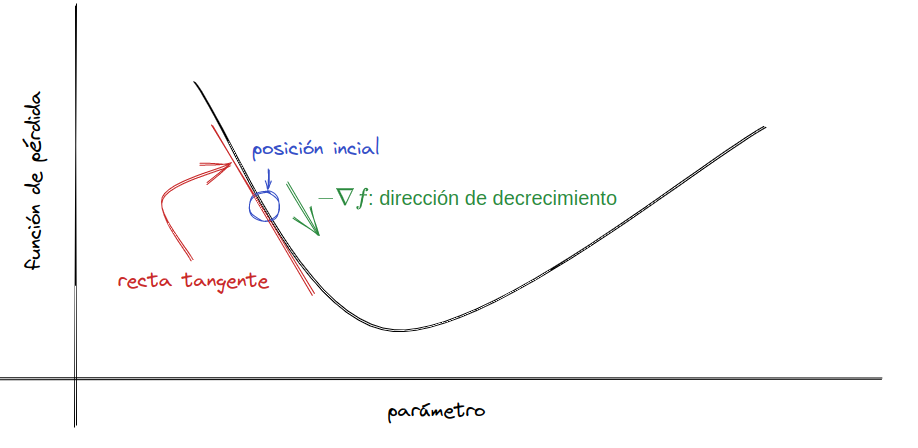

Tal vez recordaran vagamente de cálculo que lo que nos indica el gradiente es la dirección de crecimiento más empinado de una función. Por ejemplo, en la figura, el gradiente en el punto inicial va a ser negativo, porque la función crece cuando disminuye el parámetro. A su vez, la magnitud del gradiente va a estar relacionado con la pendiente de la recta tangente a la función en el punto, cuanto mayor sea la pendiente, mayor la magnitud del gradiente. Podemos pensar esto último como que tan rápidamente reacciona la función ante cambios del parámetro. 

Si lo que queremos es disminuir la función de pérdida, entonces lo que tenemos que hacer es modificar los parámetros en la dirección contraria a la que indica el gradiente, es decir: $- \nabla f$. 

Podemos hacer lo mismo repetidamente, nos movemos un poquito en la dirección opuesta al gradiente, lo volvemos a calcular, nos movemos nuevamente y así. Eventualmente deberíamos pasar por el mínimo. Lo que acabamos de describir recibe el nombre de descenso por gradiente (gradient descent) y es el método por excelencia de optimización que se utiliza para todos los algoritmos de aprendizaje profundo.

<!-- ![Descenso por el gradiente](images/descenso_por_gradiente.svg) -->

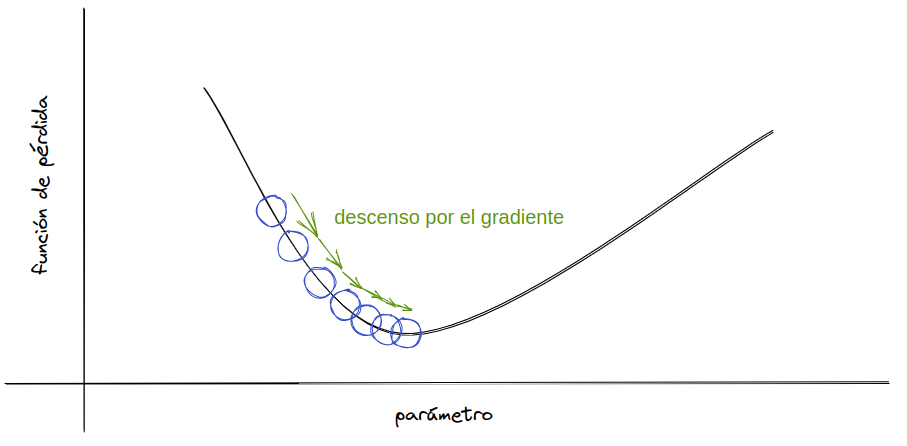




### La tasa de aprendizaje (learning rate)

Una cosa que nos queda por determinar es de qué tamaño hacemos los pasos. Fácilmente nos vamos podemos dar cuenta de que si los pasos son muy pequeños, el modelo va a tardar mucho en converger. Mientras que si los pasos son muy grandes, la solución va a oscilar de un lado a otro y no alcanzará nunca el mínimo. 

En general se suele tomar el tamaño des paso como proporcional a la magnitud del gradiente. La razón para hacerlo proporcional al gradiente es que a medida que nos aproximamos al mínimo de la función de pérdida, la pendiente de la curva debería ir aproximándose al cero, y en consecuencia los pasos se irían reduciendo con ella. El efecto es que el algoritmo naturalmente evoluciona más lento en las cercanías del mínimo y eso evita que haya overshooting. 

El paso nos queda entonces como:

$$ dx = - lr \nabla f $$ 

donde $lr$ es una contastante denominada "learning rate". 

Para determinar el valor adecuado de learning rate no hay una fórmula exacta, generalmente se prueban disitntos rangos de valores (0.0001, 0.001, 001, 0.1) hasta que se encuentra uno que funciona bien. 

### Cómo calcular el gradiente

Lo más complicado del método parece ser el cálculo del gradiente. Tal vez recuerden de sus clases de matemática que el gradiente estaba relacionado con las derivadas, particularmente las derivadas parciales de la función con respecto a cada parámetro de la función. Y tal vez recuerden qué la derivada parcial nos decía cuanto cambia el valor de una función si modificamos un parámetro. En el caso simple anterior, cómo hay un solo parámetro, la única derivada que importa es con respecto a ese parámetro y en consecuencia el gradiente es simplemente un número (positivo o negativo dependiendo de la posición con respecto al mínimo en la que nos encontremos). Pero si tenemos más parámetros, nos va a importar la tase de cambio para cada uno de ellos, y el gradiente va a pasar a ser un vector n-dimensional (una dimensión por parámetro). Las componentes del vector van a ser las derivadas parciales con respecto a cada parámetro. 


![Un ejemplo de descenso por gradiente para una función de pérdida con dos parámetros](images/2D_gradient_descent.gif)

A esta altura les puede estar preocupando exactamente cómo hay que calcular todas esas derivadas. Sin embargo, resulta que las plataformas de aprendizaje automático como TensorFLow y PyTorch son capaces de calcular automáticamente las derivadas de casi cualquier función, incluso de funciones definidas por nosotros a través de código. Veamos cómo lo hace.


Para hacer la diferenciación automática, TensorFLow necesita registrar todas las operaciones que ocurrieron y en qué orden. Luego, TensorFlow recorre la lista de operaciones en reversa para calcular todas las derivadas. 

TensorFlow proporciona la API `tf.GradientTape` para la diferenciación automática; es decir, calcular el gradiente de un cálculo con respecto a algunas entradas. TensorFlow "graba" las operaciones relevantes ejecutadas dentro del contexto de un `tf.GradientTape` en una "cinta". Luego, TensorFlow usa esa cinta para calcular los gradientes de un cálculo "grabado" mediante la diferenciación de modo inverso.

Por ejemplo: 

In [9]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

Podemos usar `GradientTape.gradient(target, sources)` para calcular el gradiente de algún objetivo (a menudo una función de pérdida) en relación con alguna fuente (a menudo los parámetros del modelo):

In [10]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

En el ejemplo anterior, x es un escalar, pero `tf.GradientTape` funciona con la misma facilidad en cualquier tensor:

In [11]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

2023-11-18 12:18:50.577406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Para obtener el gradiente de `loss` con respecto a ambas variables, podemos pasar ambas como fuentes al método de `gradient`. La cinta es flexible acerca de cómo se pasan las fuentes y aceptará cualquier combinación anidada de listas o diccionarios y devolverá las derivadas estructuradas de la misma manera.

In [12]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print(f"dl_dw: {dl_dw}")
print(f"dl_db: {dl_db}")

dl_dw: [[-1.5035867e-03  5.3037028e+00]
 [-3.0071733e-03  1.0607406e+01]
 [-4.5107598e-03  1.5911108e+01]]
dl_db: [-1.5035867e-03  5.3037028e+00]


## Poniendo todas las piezas juntas

Ahora que:

1. Tenemos un modelo que determina un resultado a partir de datos y "parámetros" internos.
2. Que podemos evaluar el modelo automáticamente a través de una función de pérdida.
3. Que tenemos mecanismo automático para disminuir la función de érdida a través de la modificación de los parámetros internos.

Lo que nos queda por hacer es juntar todas las piezas

In [13]:
W = tf.random.normal(shape=[1, 3072])
b = tf.zeros(shape=[])

# create model variables
W = tf.Variable(W)
b = tf.Variable(b)

model_variables = [W, b]

epochs = 10
learning_rate = 0.01
train_losses = []

for epoch in range(epochs):
    epoch_loss = []

    with tf.GradientTape() as tape:
        for image, y_true in train_data:
            
            y_true = tf.cast(y_true, tf.float32)
            logits = tf.add(tf.matmul(W, image), b)
            logits = tf.squeeze(logits)
            epoch_loss.append(tf.nn.sigmoid_cross_entropy_with_logits(y_true, logits))

        train_loss = tf.reduce_mean(epoch_loss)

        # compute gradient
        grads = tape.gradient(train_loss, model_variables)

        # update the model
        for dv, variable in zip(grads, model_variables):
            variable.assign_sub(learning_rate * dv)

    # keep track of the loss
    train_losses.append(train_loss)
    print(f"Epoch: {epoch}, Training loss: {train_loss:.3f}")

Epoch: 0, Training loss: 15.727
Epoch: 1, Training loss: 14.197
Epoch: 2, Training loss: 12.701
Epoch: 3, Training loss: 11.254
Epoch: 4, Training loss: 9.881
Epoch: 5, Training loss: 8.612
Epoch: 6, Training loss: 7.491
Epoch: 7, Training loss: 6.554
Epoch: 8, Training loss: 5.819
Epoch: 9, Training loss: 5.281


Text(0, 0.5, 'loss')

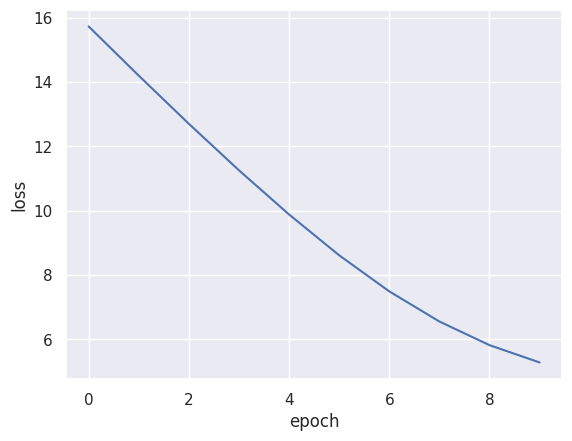

In [14]:
ax = sns.lineplot(x=range(epochs), y=[loss.numpy() for loss in train_losses])
ax.set_xlabel("epoch")
ax.set_ylabel("loss")


## Stochastic Gradient Descent (SGD)

Un problema del código anterior es que no es demasiado eficiente, el problema está en que estamos iterando sobre cada imagen. Lo que resulta conveniente es agrupar los datos en batches e iterar sobre esos batches. Lo que logramos es que TensorFlow pueda agrupar las operaciones algebraicas de manera más eficiente. 

Para facilitar la creación de batches, `tf.Dataset` ofrece la funcion `batch` que justamente agrupa los datos en subconjuntos del tamaño que queramos.

In [15]:
batched_train_data = train_data.batch(32)

Cuando el cálculo del gradiente no se hace utilizando todos los datos, sino en un subset al azar de los datos, eso se conoce como descenso por gradiente stocástico (Stochastic Gradient Descent, o SGD)

In [16]:
W = tf.random.normal(shape=[1, 3072])
b = tf.zeros(shape=[])

# create model variables
W = tf.Variable(W)
b = tf.Variable(b)

model_variables = [W, b]

epochs = 10
learning_rate = 0.01
train_losses = []

for epoch in range(epochs):
    batch_losses = []
    
    for image_batch, y_true_batch in batched_train_data:
        with tf.GradientTape() as tape:
          
            y_true_batch = tf.cast(y_true_batch, tf.float32)
            logits = tf.add(tf.matmul(W, image_batch), b)
            logits = tf.squeeze(logits)
            batch_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y_true_batch, logits))
            batch_losses.append(batch_loss)

        # compute gradient
        grads = tape.gradient(batch_loss, model_variables)

        # update the model
        for dv, variable in zip(grads, model_variables):
            variable.assign_sub(learning_rate * dv)

    # keep track of the loss
    train_loss = tf.reduce_mean(batch_losses)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch}, Training loss: {train_loss:.3f}")

2023-11-18 12:24:05.861367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [6]
	 [[{{node Placeholder/_1}}]]
2023-11-18 12:24:05.861800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [6]
	 [[{{node Placeholder/_4}}]]


Epoch: 0, Training loss: 4.317
Epoch: 1, Training loss: 3.490
Epoch: 2, Training loss: 3.145
Epoch: 3, Training loss: 2.918
Epoch: 4, Training loss: 2.749
Epoch: 5, Training loss: 2.613
Epoch: 6, Training loss: 2.501
Epoch: 7, Training loss: 2.406
Epoch: 8, Training loss: 2.325
Epoch: 9, Training loss: 2.254


Text(0, 0.5, 'loss')

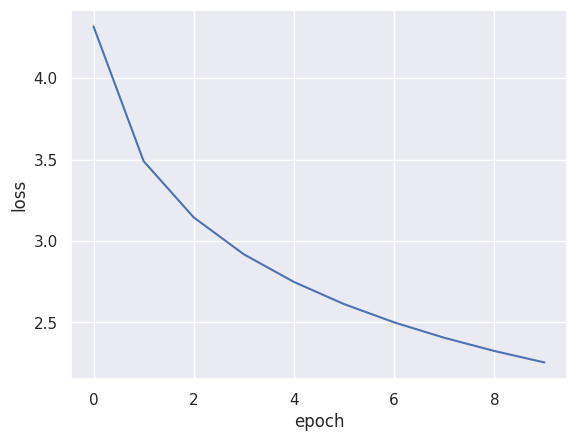

In [17]:
ax = sns.lineplot(x=range(epochs), y=[loss.numpy() for loss in train_losses])
ax.set_xlabel("epoch")
ax.set_ylabel("loss")


## Respecto al problema de las imágenes corrompidas.

Si bien hay mensajes de error en algunos casos, el siguiente código muestra que los datos son leídos correctamente. [Hay un open issue al respecto en GitHub](https://github.com/tensorflow/datasets/issues/2188)

In [18]:
data, info = tfds.load('cats_vs_dogs', split="train", with_info=True)
from PIL import Image

for x in data:
    img = Image.fromarray(x["image"].numpy())

    # Raise an exception if image is Invalid
    img.verify()

2023-11-18 12:24:23.404209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-11-18 12:24:23.404495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 ex

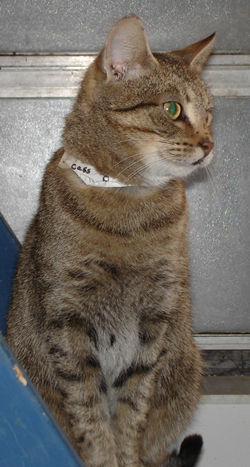

In [19]:
img